In [ ]:
#For compatability, we use XGBoost 2.1.2 and Skikit-learn 1.3.2:

!pip install --upgrade pip
!pip install pingouin
!pip install pyampute
!pip install shap

!pip uninstall -y scikit-learn xgboost numpy
!pip install scikit-learn==1.3.2
!pip install xgboost==2.1.2
!pip install numpy==1.23.1 --only-binary :all:

#Restart session

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
EP RQ2 Model Final

Author: Joseph Toland; Validation: Anchal Bansal
"""

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import scipy.stats as stats
import io
import sklearn
import matplotlib.patches as mpatches

from scipy.stats import ttest_1samp, spearmanr

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc)

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely.geometry import Point

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
from google.colab import files

sns.set(style='white')  # white, darkgrid


In [2]:
print(f"XGBoost version: {xgb.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

XGBoost version: 2.1.2
scikit-learn version: 1.3.2


In [3]:
# Upload a CSV file using files.upload()
uploaded = files.upload()

# Get the first uploaded file (assuming it's a CSV)4
uploaded_file_name = list(uploaded.keys())[0]

# Create a DataFrame from the uploaded CSV file
source = pd.read_csv(io.StringIO(uploaded[uploaded_file_name].decode('utf-8')))

Saving SURVEY_ANALYSIS_FINAL_RQ2_101724_DATA.csv to SURVEY_ANALYSIS_FINAL_RQ2_101724_DATA.csv


#Survey Validation

In [ ]:
# Upload the CSV
uploaded = files.upload()

# Get the first uploaded file
uploaded_file_name = list(uploaded.keys())[0]

# Create a DataFrame from the uploaded CSV file
source_CN = pd.read_csv(io.StringIO(uploaded[uploaded_file_name].decode('utf-8')))

source_CN.dropna(inplace = True) #to check a clean version with all NA removed for Cronback and rWg. Use: SURVEY_ANALYSIS_FINAL_RQ2_101224_CRONBACH.csv
source_CN['P-WSAFETY-10'] = pd.to_numeric(source_CN['P-WSAFETY-10'], errors='coerce')

uploaded = files.upload()

# Get the first uploaded file
uploaded_file_name = list(uploaded.keys())[0]

# Create a DataFrame from the uploaded CSV file #to check missingness with NO NA removed. Use: SURVEY_ANALYSIS_FINAL_RQ2_101224_TESTS.csv
source_T = pd.read_csv(io.StringIO(uploaded[uploaded_file_name].decode('utf-8')))

Run Little MCAR Test  

In [ ]:
# Little MCAR TEST
import pyampute as pyampute
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Conduct the MCAR test
mt = MCARTest(method="little")
p_value = mt.little_mcar_test(source_T)  # This should directly return the p-value.  Note be sure to use the data from BEFORE demogrpahic varibles have been matched to categorical reference categories.

# Print the p-value
print("P-Value from Little's MCAR Test:", p_value)

# Interpret the p-value
if p_value < 0.05:
    print("The missing data is not MCAR (reject the null hypothesis).")
else:
    print("The missing data can be considered MCAR (fail to reject the null hypothesis).")


 Cronback Alpha Test

In [ ]:
from pingouin import cronbach_alpha

WSAFE = source_CN[['P-WSAFETY-1', 'P-WSAFETY-2', 'P-WSAFETY-3', 'P-WSAFETY-4',
       'P-WSAFETY-5', 'P-WSAFETY-6', 'P-WSAFETY-7', 'P-WSAFETY-8',
       'P-WSAFETY-9', 'P-WSAFETY-10', 'P-WSAFETY-11']]

EQF = source_CN[['P-SOC-EQF-1', 'P-SOC-EQF-2', 'P-SOC-EQF-3', 'P-SOC-EQF-4']]

TRUST = source_CN[['P-TRUST-1', 'P-TRUST-2', 'P-TRUST-3', 'P-TRUST-4', 'P-TRUST-5',
       'P-TRUST-6', 'P-TRUST-7', 'P-TRUST-8', 'P-TRUST-9', 'P-TRUST-10',
       'P-TRUST-11', 'P-TRUST-12', 'P-TRUST-13', 'P-TRUST-14', 'P-TRUST-15',
       'P-TRUST-16', 'P-TRUST-17', 'P-TRUST-18', 'P-TRUST-19']]

alpha_result = cronbach_alpha(WSAFE)
print("Cronbach's Alpha for W-SAFETY:", round(alpha_result[0], 2))

alpha_result = cronbach_alpha(TRUST)
print("Cronbach's Alpha for W-TRUST:", round(alpha_result[0], 2))

alpha_result = cronbach_alpha(EQF)
print("Cronbach's Alpha for P-SOC-EQF:", round(alpha_result[0], 2))

One Sample, Two-Sided T-Test for the RwG Test

In [ ]:
# Specify the hypothesized mean
hypothesized_mean = 3

# Create a dictionary to store the results and list of DataFrames
results = {}
dataframes = [WSAFE, EQF, TRUST]

# Perform one-sample t-test for each DataFrame
for df_label, df in zip(['WSAFE', 'EQF', 'TRUST'], dataframes):
    # Create a new DataFrame for each column
    df_columns = {col: df[col] for col in df.columns}

    # Remove NA values for each column
    df_no_na = {col: col_data.dropna() for col, col_data in df_columns.items()}

    # Perform the one-sample t-test for each column again
    t_statistic = []
    p_value = []
    for col, col_data in df_no_na.items():
        t_stat, p_val = ttest_1samp(col_data, hypothesized_mean)
        t_statistic.append(t_stat)
        p_value.append(p_val)

    # Store the results in the dictionary
    results[df_label] = {'t_statistic': t_statistic, 'p_value': p_value}

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Apply the styling to the 'p_value' column
styled_results = results_df.style.applymap(lambda x: highlight_significance(x) if 'p_value' in x else '')

# Display the styled DataFrame. This take some interpretation, we find all p values greater than 0.05 for investigation that fail the test. Then associated the predictor based on the order.  These are then selected for RwG test.
styled_results


rWG Within Group Reliability Test

In [ ]:
# Function to calculate rWG for Likert scale variables without grouping

variable_columns = ['P-WSAFETY-1', 'P-WSAFETY-4', 'P-WSAFETY-5','P-TRUST-1', 'P-TRUST-3'] #these must be from the p values that are high above where we compare them all to see if there is a central tendency selection bias

def calculate_rWG(data, variable_columns):
    # Step 1: Remove NaN values from the specified columns
    cleaned_data = data[variable_columns].dropna()

    # Step 2: Calculate Total Variance for Likert scale variables
    total_variance = np.var(cleaned_data.values.flatten(), ddof=1)

    # Step 3: Calculate Within-Group Variance for Likert scale variables
    within_group_variance = cleaned_data.apply(lambda x: ((x - x.mean())**2).sum()).mean()

    # Step 4: Calculate rWG for Likert scale variables
    k = len(variable_columns)
    rWG = within_group_variance / (total_variance + (k - 1) * within_group_variance)

    return rWG

# Calculate rWG for all variables together, removing NaN values
rWG_value = calculate_rWG(source_CN, variable_columns)

# Print the result
print(f'rWG Value for all variables: {rWG_value}')


Class imbalance test

In [ ]:
import pandas as pd

# Check for class imbalance in all binary/categorical columns
threshold_ratio = 0.1  # Threshold for imbalance (10:1 imbalance)

# Iterate through each column in the dataset
for column in source.columns:
    # Skip non-binary columns
    if source[column].nunique() > 2:
        print(f"Skipping column '{column}' (not binary/categorical).")
        continue

    print(f"\nChecking imbalance for column: {column}")

    # Get the distribution of classes
    class_distribution = source[column].value_counts()
    print("Class distribution:")
    print(class_distribution)

    # Calculate imbalance ratio
    imbalance_ratio = class_distribution.min() / class_distribution.max()

    # Print whether the column exceeds the imbalance threshold
    if imbalance_ratio < threshold_ratio:
        print(f"Imbalance ratio: {imbalance_ratio:.2f}. This exceeds the 10:1 threshold, indicating class imbalance.")
    else:
        print(f"Imbalance ratio: {imbalance_ratio:.2f}. This does not exceed the 10:1 threshold, indicating no class imbalance.")


#Descriptive Statistics, Chi-Sqares Tests, and Corelations

Descriptive Statistics

In [ ]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
mean_std_min_max_summary = source.describe().loc[['mean', 'std', 'min', 'max']].round(2)
print(mean_std_min_max_summary)

Chi-square tests

In [ ]:
source_CHI = source

source_CHI.dropna(inplace=True)  # Clean version with all NAs removed (n = 181).

# Select categorical variables for Chi-square tests
chi = source_CHI[['R-WINSEC', 'P-OWNRENT', 'P-WWELL', 'P-WMUNICIPAL', 'P-WCHANGE',
                  'P-WRELIEF', 'P-WPURCHASE', 'P-RISK-W', 'P-WTREAT', 'P-ACTION-R',
                  'P-EDU-HS', 'P-INCOME-50', 'P-COUNTY','P-GENDER', 'P-WORK-Y']]

variables = chi.columns.tolist()
results = pd.DataFrame(columns=variables, index=variables)

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i > j:
            contingency_table = pd.crosstab(chi[var1], chi[var2])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            results.at[var1, var2] = round(p, 2)
        elif i == j:  # On the diagonal
            results.at[var1, var2] = np.nan

# Highlight p-values
def highlight_associated(val):
    if np.isnan(val):
        return "color: rgba(0, 128, 0, 0)"
    if val <= 0.01:
        return "color: red"
    if val <= 0.05:
        return "color: orange"
    return ""

# Style and display the DataFrame
styled_results = results.style.format(precision=2).applymap(highlight_associated)
styled_results


Spearman Rank Correlation

In [ ]:
# Selecting only the Likert and all other non-categorical variables
spear = source[['P-SOC-EQF','P-WSAFETY','P-TRUST','P-HH-POP', 'P-HH-CHILD','P-WQUANT-G', 'P-WQUANT-EM','P-ACTION-R']] #note, chldren and large families are correlated, as are water stoarge and eemergneyc storage for SI

# Calculating Spearman's rank correlation coefficients
correlations = spear.corr(method='spearman')

# Calculating p-values for correlations
p_values = spear.corr(method=lambda x, y: spearmanr(x, y)[1])[['P-SOC-EQF','P-WSAFETY','P-TRUST','P-HH-POP', 'P-HH-CHILD','P-WQUANT-G', 'P-WQUANT-EM','P-ACTION-R']]

pd.options.display.float_format = '{:.2f}'.format

print("Correlations:")
print(correlations[['P-SOC-EQF','P-WSAFETY','P-TRUST','P-HH-POP', 'P-HH-CHILD','P-WQUANT-G','P-WQUANT-EM','P-ACTION-R']])
print("\nP-values:")
print(p_values)


Data Exploration: BoxPlots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

source_BOXBI = source.copy()
source_BOXBI.dropna(inplace=True)  # Drop rows with missing values
source_BOXBI = source_BOXBI.drop(['INDEX'], axis=1)  # Drop the 'INDEX' column

# Mapping of variable codes to their simplified descriptions
variable_mapping = {
    'R-HWISE': 'HWISE score',
    'R-WINSEC': 'Water insecure (HWISE)',
    'P-WWELL': 'Household normally used\nprivate well water',
    'P-WMUNICIPAL': 'Household normally used\nmunicipal water',
    'P-WCHANGE': 'Change in water source',
    'P-WRELIEF': 'Used donated bottled\nwater (after)',
    'P-WPURCHASE': 'Purchased bottled\nwater (after)',
    'P-HH-POP': 'Number of people in\nhousehold',
    'P-HH-CHILD': 'Number of children\nin household',
    'P-INCOME-50': 'Income (< 50K)',
    'P-OWNRENT': 'Tenure (owner)',
    'P-EDU-HS': 'Education (12 years or less)',
    'P-WORK-Y': 'Employment (working full\nor part time)',
    'P-GENDER': 'Gender (female)',
    'P-AGE-65': 'Age (> 65 years)',
    'P-WSAFETY': 'Perceptions of water safety',
    'P-TRUST': 'Perceptions of trust',
    'P-COUNTY': 'County (Columbiana)',
    'P-SOC-EQF': 'Perceptions of equity\nand fairness',
    'P-RISK-W': 'Told drinking water\nwas unsafe',
    'P-WTREAT': 'Installed a home water treatment\nsystem or filters',
    'P-ACTION-R': 'Relocation',
    'P-WQUANT-EM': 'Emergency water',
    'P-WQUANT-G': 'Water storage (gallons)',
    'P-INT-1': 'Interaction: Water safety and\nchange',
    'P-INT-2': 'Interaction: Water safety,\nchange, and used\ndonated water'
}

# Rename the columns in the DataFrame
source_BOXBI.rename(columns=variable_mapping, inplace=True)

# Updated list of variables to plot (after renaming)
variables = list(variable_mapping.values())

# Dynamically calculate the grid size
import math
n_vars = len(variables)
n_cols = 5  # Fixed number of columns
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 18))

# Flatten the axes to make it easier to loop through
axes = axes.flatten()

# Loop through each variable and create a boxplot
for i, var in enumerate(variables):
    ax = axes[i]

    # Create box plot for each variable
    source_BOXBI.boxplot(column=var, ax=ax, patch_artist=True,  # Patch for color fill
                         boxprops=dict(facecolor='lightgrey', color='black'),  # Box color
                         whiskerprops=dict(color='black'),  # Whisker color
                         capprops=dict(color='black'))  # Cap color

    # Set only the Y-axis label
    ax.set_ylabel('Values', fontsize=12)  # Y-axis label

    # Remove the x-axis label by not setting it
    ax.set_xlabel(None)

    # Optionally adjust y-axis to fit data better (if needed)
    ax.set_ylim(source_BOXBI[var].min() - 1, source_BOXBI[var].max() + 1)

# Hide any unused subplots
for ax in axes[n_vars:]:
    ax.axis('off')

# Adjust layout to prevent overlap and give space for titles
fig.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjust the space at the top to avoid title overlap

# Customize font and style for publication
sns.set_style("whitegrid")  # Use a clean, professional background
plt.rcParams.update({'font.size': 10, 'font.family': 'times new roman'})  # Update font size and style

# Save the plot as a high-quality image (300 DPI) for publication
plt.savefig("boxplot_matrix.png", dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


Likelihood Ratio Test

In [ ]:
from scipy.stats import chi2, spearmanr
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

model_full = result  # This is the full model using 'remaining_features'

# Create reduced feature set by dropping 'P-WSAFETY'
reduced_features = [f for f in remaining_features if f != 'P-WSAFETY']
X_reduced = sm.add_constant(X[reduced_features])
model_reduced = sm.Logit(Y, X_reduced).fit()

# --- 1. Likelihood Ratio Test ---
lr_stat = 2 * (model_full.llf - model_reduced.llf)
p_value = chi2.sf(lr_stat, df=1)  # df=1 because one predictor ('P-WSAFETY') is removed

print("Likelihood Ratio Test statistic:", lr_stat)
print("p-value:", p_value)

# --- 2. AUC (Area Under the ROC Curve) ---
# Use 'remaining_features' for the full model
clf_full = LogisticRegression(max_iter=1000)
clf_full.fit(X[remaining_features], Y.values.ravel())
auc_full = roc_auc_score(Y, clf_full.predict_proba(X[remaining_features])[:, 1])

# Use 'reduced_features' for the reduced model
clf_reduced = LogisticRegression(max_iter=1000)
clf_reduced.fit(X[reduced_features], Y.values.ravel())
auc_reduced = roc_auc_score(Y, clf_reduced.predict_proba(X[reduced_features])[:, 1])

print("\nAUC Full Model:", auc_full)
print("AUC Reduced Model:", auc_reduced)
print("AUC Difference (Variable's contribution):", auc_full - auc_reduced)

# --- 3. Spearman's Rank Correlation ---
# Calculate the Spearman's correlation between 'P-WSAFETY' and 'R-WINSEC'
corr, spearman_p = spearmanr(source_LR['P-WSAFETY'], source_LR['R-WINSEC'])
print("\nSpearman's rank correlation between P-WSAFETY and R-WINSEC:", corr)
print("Spearman's p-value:", spearman_p)


# Logistic Regression Model

Process data

In [60]:
source_LR = source.drop(['INDEX'],axis=1)
source_LR.dropna(inplace = True) #to check a clean version with all drop these to get to 181:

In [61]:
#Defining Xs, and Y
X = source_LR.drop(columns=['R-WINSEC', 'R-HWISE'])  #add or remove interaction effects
Y = source_LR[['R-WINSEC']]

columns_to_scale = ['P-WQUANT-G', 'P-WQUANT-EM', 'P-WSAFETY', 'P-TRUST','P-SOC-EQF','P-HH-POP', 'P-HH-CHILD' ] # We scale these columns so all values of coefficent are comparable by magnitude

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the specified columns
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])


Logisitc regression model evaluation

Step 1: Removing feature: P-HH-CHILD, p-value: 0.9836, VIF: 5.56, AIC without: 167.42
Step 2: Removing feature: P-INT-1, p-value: 0.9579, VIF: 16.94, AIC without: 165.42
Step 3: Removing feature: P-INT-2, p-value: 0.8285, VIF: 2.77, AIC without: 163.47
Step 4: Removing feature: P-TRUST, p-value: 0.8176, VIF: 8.20, AIC without: 161.52
Step 5: Removing feature: P-INCOME-50, p-value: 0.7827, VIF: 2.20, AIC without: 159.60
Step 6: Removing feature: P-EDU-HS, p-value: 0.6294, VIF: 1.40, AIC without: 157.83
Step 7: Removing feature: P-WORK-Y, p-value: 0.6453, VIF: 3.46, AIC without: 156.04
Step 8: Removing feature: P-RISK-W, p-value: 0.6539, VIF: 1.22, AIC without: 154.25
Step 9: Removing feature: P-SOC-EQF, p-value: 0.6448, VIF: 3.43, AIC without: 152.46
Step 10: Removing feature: P-WTREAT, p-value: 0.2420, VIF: 1.27, AIC without: 151.83
Step 11: Removing feature: P-WMUNICIPAL, p-value: 0.1874, VIF: 40.03, AIC without: 151.45
Step 12: Removing feature: P-WWELL, p-value: 0.3884, VIF: 1.91, A

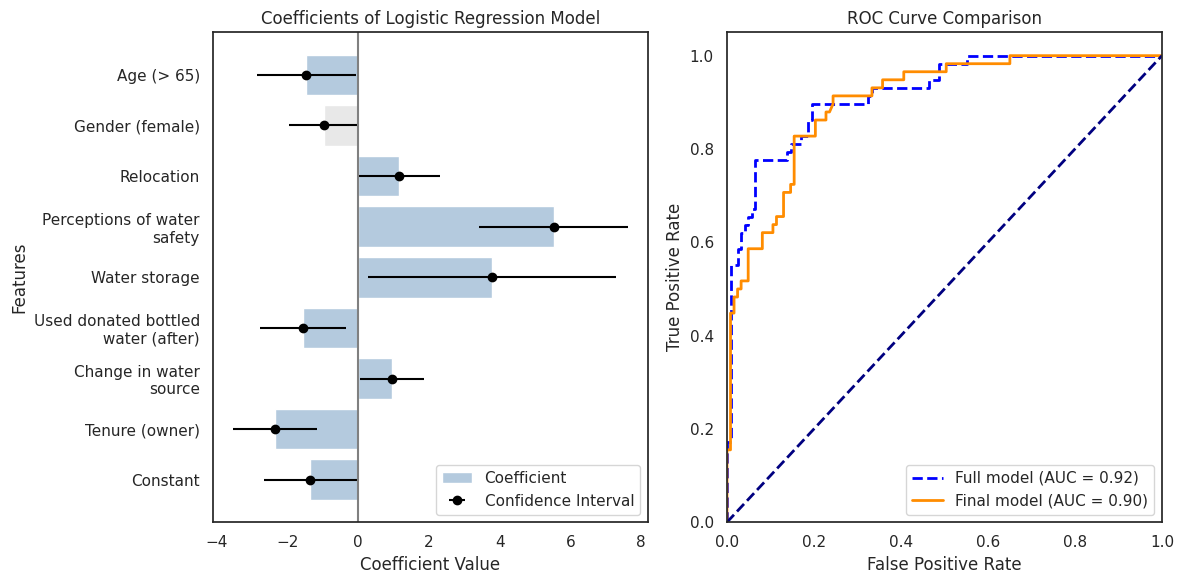


VIF of remaining features:
      Feature       VIF
0   P-OWNRENT  3.272734
1   P-WCHANGE  1.837013
2   P-WRELIEF  1.498655
3  P-WQUANT-G  1.725364
4   P-WSAFETY  2.788075
5  P-ACTION-R  1.448121
6    P-GENDER  2.547889
7    P-AGE-65  1.377933


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc

def calculate_vif(X):
    """Calculate Variance Inflation Factor (VIF) for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

def backward_selection(X, target, significance_level=0.1, max_iter=1000):
    """Perform backward feature selection with logistic regression."""
    remaining_features = list(X.columns)
    step = 1

    while remaining_features:
        X_subset = sm.add_constant(X[remaining_features])  # Add constant term
        logit_model = sm.Logit(target, X_subset)
        result = logit_model.fit(maxiter=max_iter, disp=0)  # Fit model with max iterations

        p_values = result.pvalues[1:]  # Exclude constant term
        max_p_value = p_values.max()
        max_p_index = p_values.idxmax()

        vif_data = calculate_vif(X[remaining_features])
        vif = vif_data.loc[vif_data['Feature'] == max_p_index, 'VIF'].values[0]

        if max_p_value > significance_level:
            X_temp = X_subset.drop(columns=[max_p_index])
            logit_model_temp = sm.Logit(target, X_temp)
            result_temp = logit_model_temp.fit(maxiter=max_iter, disp=0)
            new_AIC = result_temp.aic

            print(f"Step {step}: Removing feature: {max_p_index}, p-value: {max_p_value:.4f}, VIF: {vif:.2f}, AIC without: {new_AIC:.2f}")
            remaining_features.remove(max_p_index)
        else:
            break

        step += 1

    # Final model summary
    X_final = sm.add_constant(X[remaining_features])
    final_model = sm.Logit(target, X_final)
    result = final_model.fit()

    print(result.summary())

    marginal_effects = result.get_margeff(at='overall')
    marginal_effects_summary = marginal_effects.summary()
    print("\nMarginal Effects for Remaining Variables in Final Model:")
    print(marginal_effects_summary)

    coefficients = result.params
    conf_int = result.conf_int()

    # Define names (customize as needed)
    defined_names = [
        'Constant',
        'Tenure (owner)',
        'Change in water\nsource',
        'Used donated bottled\n water (after)',
        'Water storage',
        'Perceptions of water\nsafety',
        'Relocation',
        'Gender (female)',
        'Age (> 65)',
    ]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    # Define colors for bars
    colors = ['#B4CADE'] * len(coefficients)
    if 'P-GENDER' in coefficients.index:
        colors[coefficients.index.get_loc('P-GENDER')] = '#E8E8E8'

    if len(defined_names) != len(coefficients):
        print("Warning: Length of defined names does not match length of coefficients.")

    coefficients.index = defined_names[:len(coefficients)]
    plt.barh(coefficients.index, coefficients.values, color=colors, label='Coefficient')

    plt.errorbar(coefficients.values, coefficients.index,
                 xerr=[coefficients.values - conf_int[0], conf_int[1] - coefficients.values],
                 fmt='o', color='black', label='Confidence Interval')

    plt.axvline(x=0, color='.5')
    plt.xlabel('Coefficient Value')
    plt.title('Coefficients of Logistic Regression Model')
    plt.ylabel('Features')
    plt.legend(loc="lower right")

    # --- ROC Curve Comparison ---
    X_full = sm.add_constant(X)
    result_full = sm.Logit(target, X_full).fit(maxiter=max_iter, disp=0)

    pred_probs_full = result_full.predict(X_full)
    fpr_full, tpr_full, _ = roc_curve(target, pred_probs_full)
    roc_auc_full = auc(fpr_full, tpr_full)

    pred_probs_final = result.predict(X_final)
    fpr_final, tpr_final, _ = roc_curve(target, pred_probs_final)
    roc_auc_final = auc(fpr_final, tpr_final)

    plt.subplot(1, 2, 2)
    plt.plot(fpr_full, tpr_full, color='blue', lw=2, linestyle='--',
             label='Full model (AUC = %0.2f)' % roc_auc_full)
    plt.plot(fpr_final, tpr_final, color='darkorange', lw=2,
             label='Final model (AUC = %0.2f)' % roc_auc_final)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('FIGURE1.png', dpi=600, bbox_inches='tight')
    plt.show()

    print("\nVIF of remaining features:")
    vif_data = calculate_vif(X[remaining_features])
    print(vif_data)

    return result, remaining_features

# Call function with our data
result, remaining_features = backward_selection(X, Y, max_iter=1000)


Run bootstrap validation for LR

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Error with iteration 203: Singular matrix


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


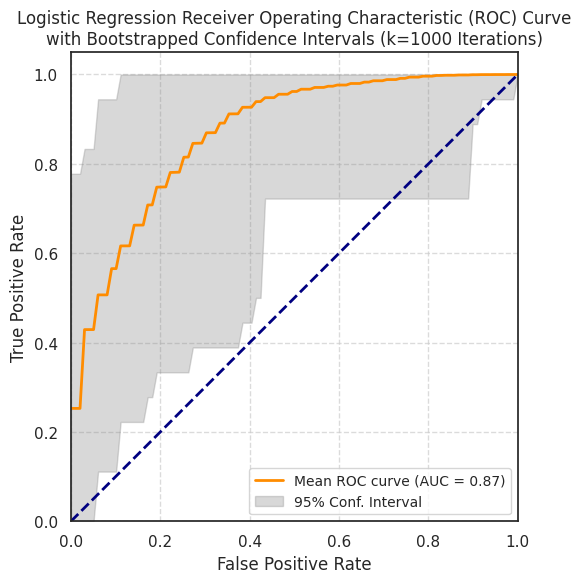

Average Accuracy: 0.79 (±0.05)
95% CI for Accuracy: (0.69, 0.87)
Average Sensitivity: 0.62 (±0.11)
95% CI for Sensitivity: (0.39, 0.83)
Average Specificity: 0.87 (±0.06)
95% CI for Specificity: (0.76, 0.97)
Average AUC: 0.87 (±0.04)
95% CI for AUC: (0.78, 0.95)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

# Compute evaluation metrics: accuracy, sensitivity, and specificity
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return accuracy, sensitivity, specificity

# Model evaluation using Logistic Regression
def evaluate_model(X_train, X_test, Y_train, Y_test, remaining_features):
    X_train_const = sm.add_constant(X_train[remaining_features])
    final_model = sm.Logit(Y_train, X_train_const)
    result = final_model.fit(disp=0)

    X_test_const = sm.add_constant(X_test[remaining_features])
    y_pred_probs = result.predict(X_test_const)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    accuracy, sensitivity, specificity = compute_metrics(Y_test, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    return accuracy, sensitivity, specificity, fpr, tpr, roc_auc

# Running the bootstrapping iterations
def run_bootstrap(X, Y, remaining_features, num_iterations=1000):
    accuracies, sensitivities, specificities = [], [], []
    aucs = []
    all_fpr = []
    all_tpr = []

    # Stratified shuffle split initialization (ensures stratification)
    sss = StratifiedShuffleSplit(n_splits=num_iterations, test_size=0.3, random_state=15)

    plt.figure(figsize=(8, 6))

    for iteration, (train_idx, test_idx) in enumerate(sss.split(X, Y)):
        try:
            # Stratified sampling with indices
            X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
            X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]

            # Get evaluation metrics
            accuracy, sensitivity, specificity, fpr, tpr, roc_auc = evaluate_model(
                X_train, X_test, Y_train, Y_test, remaining_features
            )
            accuracies.append(accuracy)
            sensitivities.append(sensitivity)
            specificities.append(specificity)
            aucs.append(roc_auc)

            all_fpr.append(fpr)
            all_tpr.append(tpr)

        except Exception as e:
            print(f"Error with iteration {iteration}: {e}")
            continue

    if len(accuracies) == 0:
        print("No successful bootstrap iterations.")
        return

    # Calculate average ROC
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)

    # Calculate upper and lower bounds for the ROC curve (95% CI)
    lower_tpr = np.min([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    upper_tpr = np.max([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)

    # Finalize and show ROC plot
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='Mean ROC curve (AUC = {:.2f})'.format(np.mean(aucs)))
    plt.fill_between(mean_fpr, lower_tpr, upper_tpr, color='grey', alpha=0.3, label='95% Conf. Interval')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve\nwith Bootstrapped Confidence Intervals (k=1000 Iterations)', fontsize=12)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.savefig('ROC_Bootstrapped_CI.png', dpi=600, bbox_inches='tight')
    plt.show()

    # Calculate Confidence Intervals (95%) for metrics
    accuracy_ci = np.percentile(accuracies, [2.5, 97.5])
    sensitivity_ci = np.percentile(sensitivities, [2.5, 97.5])
    specificity_ci = np.percentile(specificities, [2.5, 97.5])
    auc_ci = np.percentile(aucs, [2.5, 97.5])

    # Print average metrics and 95% CI
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_auc = np.mean(aucs)

    std_accuracy = np.std(accuracies)
    std_sensitivity = np.std(sensitivities)
    std_specificity = np.std(specificities)
    std_auc = np.std(aucs)

    print(f"Average Accuracy: {avg_accuracy:.2f} (±{std_accuracy:.2f})")
    print(f"95% CI for Accuracy: ({accuracy_ci[0]:.2f}, {accuracy_ci[1]:.2f})")
    print(f"Average Sensitivity: {avg_sensitivity:.2f} (±{std_sensitivity:.2f})")
    print(f"95% CI for Sensitivity: ({sensitivity_ci[0]:.2f}, {sensitivity_ci[1]:.2f})")
    print(f"Average Specificity: {avg_specificity:.2f} (±{std_specificity:.2f})")
    print(f"95% CI for Specificity: ({specificity_ci[0]:.2f}, {specificity_ci[1]:.2f})")
    print(f"Average AUC: {avg_auc:.2f} (±{std_auc:.2f})")
    print(f"95% CI for AUC: ({auc_ci[0]:.2f}, {auc_ci[1]:.2f})")

# Call the function with your data
run_bootstrap(X, Y, remaining_features, num_iterations=1000)


#XGBoost Model

Data processing

In [64]:
#Final veriables slected based on research questions and hypotheses in paper, base don n = 222 full dataset in source
X = source.drop(columns=['INDEX','R-WINSEC', 'R-HWISE','P-INT-1', 'P-INT-2']) #'P-EVAC', 'P-44413', 'P-44441', 'P-16115', 'P-16120', 'P-ZIP-4'
Y = source[['R-WINSEC']]

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.1,random_state= 15,  stratify=source['R-WINSEC'] )

XGBoost Model Evaluation

In [65]:
# Define and initialize the XGBoost model, based on hyperparameter selection with some final tuning
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    objective='binary:logistic',
    subsample=1,
    gamma=0,
    reg_lambda=1,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
)

# Fit the model on the training data
xgb_model.fit(train_x, train_y)

# Make predictions and calculate metrics
xgb_train_predictions = xgb_model.predict(train_x)
xgb_test_prob_predictions = xgb_model.predict_proba(test_x)[:, 1]
xgb_full_model_predictions = xgb_model.predict_proba(X)[:, 1]
xgb_full_model_binary_predictions = (xgb_full_model_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

XGBoost Visualization - ROC Curve

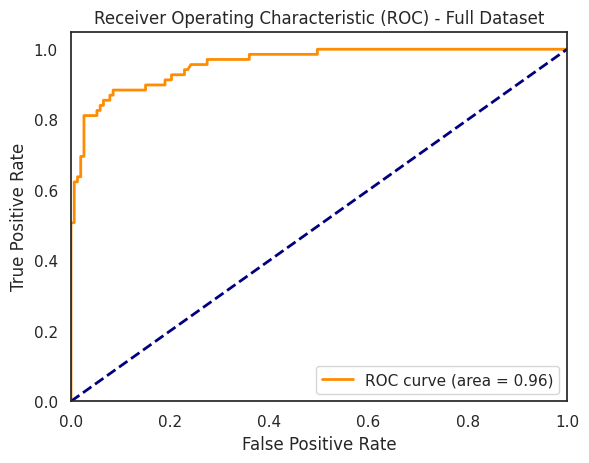

XGBoost Full Dataset AUC: 0.96


In [66]:
# Make probability predictions on the full dataset
xgb_probs_full = xgb_model.predict_proba(X)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr_full, tpr_full, thresholds_full = roc_curve(Y, xgb_probs_full)

# Calculate the AUC for the full dataset
roc_auc_full = auc(fpr_full, tpr_full)

# Plot the ROC curve for the full dataset
plt.figure()
plt.plot(fpr_full, tpr_full, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_full)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Full Dataset')
plt.legend(loc="lower right")
plt.savefig('ROC_XGBt.png', dpi=600, bbox_inches='tight')
plt.show()

# Print the AUC for the full dataset
print("XGBoost Full Dataset AUC: {0:.2f}".format(roc_auc_full))

SHAP Feature Importance Summary Plot

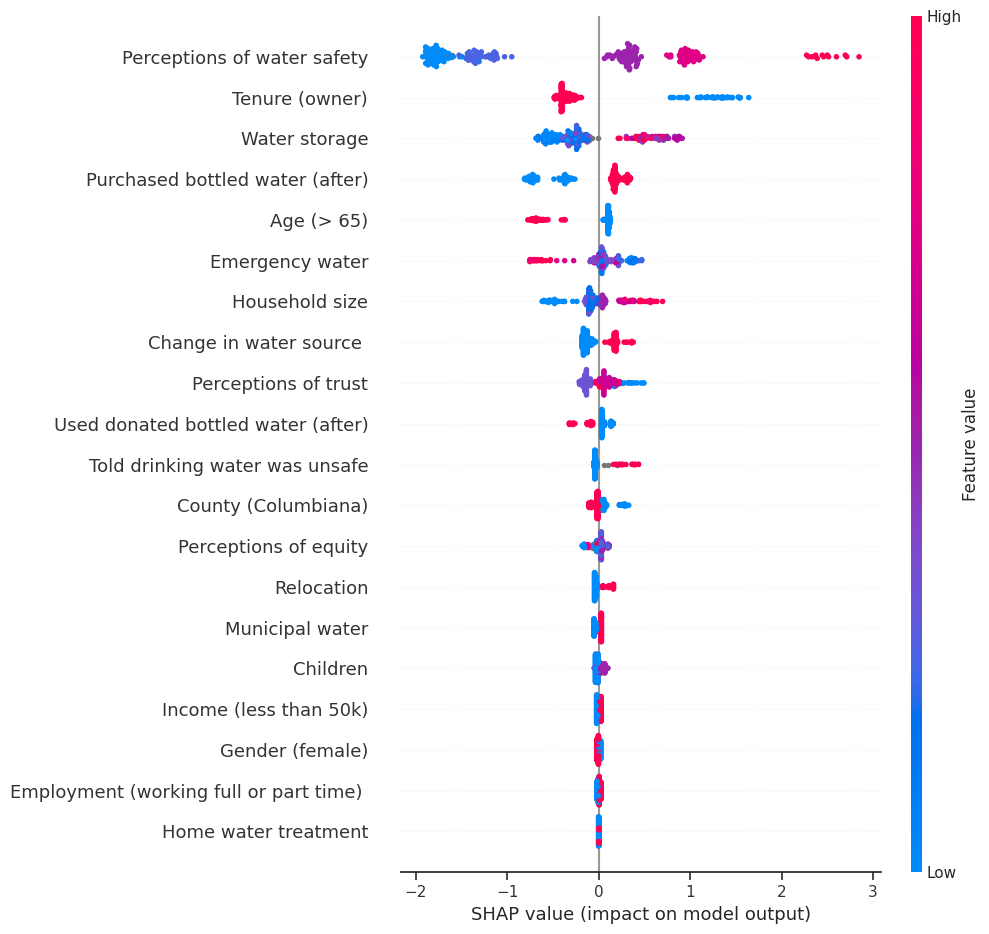

In [55]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for all features on the full dataset X
shap_values = explainer.shap_values(X)

# Create a summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, show=False)

# Define specific names for each feature
custom_labels = [
  'Home water treatment',
	'Employment (working full or part time) ',
	'Gender (female)',
	'Income (less than 50k)',
	'Children',
	'Municipal water',
	'Relocation',
	'Perceptions of equity',
	'County (Columbiana)',
	'Told drinking water was unsafe',
	'Used donated bottled water (after)',
	'Perceptions of trust',
  'Change in water source ',
	'Household size',
	'Emergency water',
	'Age (> 65)',
	'Purchased bottled water (after)',
	'Water storage',
	'Tenure (owner)',
	'Perceptions of water safety',
]

# Modify y-tick labels after the plot is created
num_features = len(custom_labels)
plt.yticks(ticks=range(num_features), labels=custom_labels)

# Save the SHAP summary plot (beeswarm plot)
plt.savefig('shap_summary_beeswarm_plot.png', dpi=600, bbox_inches='tight')
plt.show()

shap.initjs()


XGBoost Model evaluation with bootstrapping

In [56]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Define and initialize the XGBoost model, based on hyperparameter selection with some final tuning
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    objective='binary:logistic',
    subsample=1,
    gamma=0,
    reg_lambda=1,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
)

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return accuracy, sensitivity, specificity

# Function to calculate AUC
def calculate_auc(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    return auc(fpr, tpr)

# Bootstrapping function
def bootstrap_evaluation(X, Y, model, num_iterations=1000, test_size=0.3):
    accuracies, sensitivities, specificities, aucs = [], [], [], []

    for i in range(num_iterations):
        # Perform bootstrapping by sampling with replacement
        X_resampled, Y_resampled = resample(X, Y, n_samples=int(X.shape[0] * (1 - test_size)), random_state=i)

        # Split the resampled data into train and test sets
        X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=test_size, random_state=i, stratify=Y_resampled)

        # Fit the model
        model.fit(X_train, Y_train)

        # Predict on test set
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        accuracy, sensitivity, specificity = compute_metrics(Y_test, y_pred)
        auc_score = calculate_auc(Y_test, y_pred_prob)

        # Store the results
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        aucs.append(auc_score)

    # Calculate averages and confidence intervals
    avg_accuracy = np.mean(accuracies)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    avg_auc = np.mean(aucs)

    ci_accuracy = np.percentile(accuracies, [2.5, 97.5])
    ci_sensitivity = np.percentile(sensitivities, [2.5, 97.5])
    ci_specificity = np.percentile(specificities, [2.5, 97.5])
    ci_auc = np.percentile(aucs, [2.5, 97.5])

    # Print results
    print(f"Average Accuracy: {avg_accuracy:.2f} (±{np.std(accuracies):.2f})")
    print(f"95% Confidence Interval for Accuracy: ({ci_accuracy[0]:.2f}, {ci_accuracy[1]:.2f})")
    print(f"Average Sensitivity: {avg_sensitivity:.2f} (±{np.std(sensitivities):.2f})")
    print(f"95% Confidence Interval for Sensitivity: ({ci_sensitivity[0]:.2f}, {ci_sensitivity[1]:.2f})")
    print(f"Average Specificity: {avg_specificity:.2f} (±{np.std(specificities):.2f})")
    print(f"95% Confidence Interval for Specificity: ({ci_specificity[0]:.2f}, {ci_specificity[1]:.2f})")
    print(f"Average AUC: {avg_auc:.2f} (±{np.std(aucs):.2f})")
    print(f"95% Confidence Interval for AUC: ({ci_auc[0]:.2f}, {ci_auc[1]:.2f})")

    return accuracies, sensitivities, specificities, aucs

accuracies, sensitivities, specificities, aucs = bootstrap_evaluation(X, Y, xgb_model, num_iterations=1000)

Average Accuracy: 0.84 (±0.05)
95% Confidence Interval for Accuracy: (0.72, 0.94)
Average Sensitivity: 0.68 (±0.14)
95% Confidence Interval for Sensitivity: (0.38, 0.93)
Average Specificity: 0.90 (±0.06)
95% Confidence Interval for Specificity: (0.76, 1.00)
Average AUC: 0.89 (±0.05)
95% Confidence Interval for AUC: (0.77, 0.98)


Permuation Importance Test

In [ ]:
erm_importance = permutation_importance(xgb_model, X, Y, n_repeats=1000, random_state=15) # run n iterations for permutation importance

# Feature names from the dataset
default_labels = X.columns.tolist()

# Custom labels for specific features
custom_labels = {
    'P-WORK-Y': 'Employment',
    'P-WMUNICIPAL': 'Municipal water',
    'P-WWELL': 'Private well',
    'P-EDU-HS': 'Education\n(high school or less)',
    'P-GENDER': 'Gender (female)',
    'P-WTREAT': 'Home water treatment',
    'P-INCOME-50': 'Income (< 50K)',
    'P-HH-CHILD': 'Children',
    'P-RISK-W': 'Told water unsafe',
    'P-AGE-65': 'Age (> 65)',
    'P-TRUST': 'Perceptions of trust',
    'P-SOC-EQF': 'Perceptions of equity',
    'P-ACTION-R': 'Relocation',
    'P-WCHANGE': 'Change in water source',
    'P-WRELIEF': 'Used donated bottled\nwater (after)',
    'P-WQUANT-EM': 'Emergency water',
    'P-WPURCHASE': 'Purchased bottled\nwater (after)',
    'P-HH-POP': 'Household size',
    'P-WQUANT-G': 'Water storage',
    'P-COUNTY': 'County (Columbiana)',
    'P-OWNRENT': 'Tenure (owner)',
    'P-WSAFETY': 'Perceptions of water\nsafety'
}

# Creating labels for the plot using the custom mapping
plot_labels = [custom_labels.get(col, col) for col in default_labels]

# Plotting the permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(9, 9))
bars = plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx],
                 xerr=perm_importance.importances_std[sorted_idx], align='center', color='#B5CBDF')

# Adding custom legend
plt.yticks(range(len(sorted_idx)), np.array(plot_labels)[sorted_idx])  # Use mapped labels
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")

plt.xlim(0, None)

mean_importance_patch = mpatches.Rectangle((0, 0), width=0.2, height=0.1, color='#B5CBDF', edgecolor='black', label='Global importance (mean)')
std_dev_patch = plt.Line2D([0, 1], [0, 0], color='black', linestyle='-', lw=1, label='± Std. Dev.')

plt.legend(handles=[mean_importance_patch, std_dev_patch], loc="lower right")

plt.savefig('PERM_XGB_Adjusted.png', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color="#4CAF50")
plt.xlabel("Mean Permutation Importance")
plt.title("Feature Importance")
plt.tight_layout()

# Save and show the plot
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


Partial dependnace plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import font_manager

# Create a custom colormap from blue (#0000F5) to red (#EA3323)
colors = ['#0000F5', '#EA3323']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a SHAP explainer object and calculate SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

# Choose the feature of interest
feature = 'P-WSAFETY'
interaction_feature = 'P-WCHANGE'

# Get the values of the feature and the interaction feature
feature_values = X[feature]
interaction_values = X[interaction_feature]

# Compute the SHAP values
shap_feature_values = shap_values[:, X.columns.get_loc(feature)]

# Sort the data
sorted_idx = np.argsort(feature_values)
sorted_feature_values = feature_values.iloc[sorted_idx]
sorted_shap_values = shap_feature_values[sorted_idx]

# Create a figure with two subplots (one for SHAP Partial Dependence plot, and the other for the stacked bar chart)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- SHAP Partial Dependence Plot ---
scatter = axs[0].scatter(
    sorted_feature_values, sorted_shap_values,
    c=interaction_values.iloc[sorted_idx], cmap=cmap, alpha=1
)

# Set font properties for Times New Roman
font_properties = font_manager.FontProperties(family='Times New Roman', weight='normal', size=12)

# Set plot labels, title, and axis ticks for the SHAP plot
axs[0].set_xlabel('Perceptions of Water Safety (High-Low)', fontsize=14, labelpad=15, fontproperties=font_properties)
axs[0].set_ylabel('SHAP Value (Impact on Model)', fontsize=14, labelpad=15, fontproperties=font_properties)
axs[0].set_title(f'Partial Dependence Plot of Change in Water Source\n (Interaction with Perception of Water Safety)', fontsize=16, pad=20, fontproperties=font_properties)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# Add colorbar with font properties
cbar = plt.colorbar(scatter, ax=axs[0])
cbar.set_label('Change in Water Source', fontsize=12, fontproperties=font_properties)
cbar.set_ticks(np.arange(int(np.min(interaction_values)), int(np.max(interaction_values)) + 1, 1))

# --- Stacked Bar Chart with Percentage Labels ---
# Create a contingency table (counts) of the two features of interest
contingency_table = pd.crosstab(X['P-WSAFETY'], X['P-WCHANGE'])

# Calculate the percentage contribution for each group
percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart on the second subplot using the custom colormap
contingency_table.plot(kind='bar', stacked=True, colormap=cmap, ax=axs[1])

# Customize the chart with labels and title
axs[1].set_xlabel('Perceptions of Water Safety (High-Low)', fontsize=14, fontproperties=font_properties)
axs[1].set_ylabel('Count', fontsize=14, fontproperties=font_properties)
axs[1].set_title('Partial Dependence Contribution', fontsize=16, fontproperties=font_properties)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

# Add percentage labels to the red parts (last column of contingency table)
for i, (group, row) in enumerate(contingency_table.iterrows()):
    # Get the cumulative height of all previous bars (for positioning)
    cumulative_height = 0
    for j, value in enumerate(row):
        if j == len(row) - 1:  # If it's the last column (red part)
            percentage = percentages.iloc[i, j]
            axs[1].text(
                i, cumulative_height + value / 2,  # Position: center of the red bar
                f'{percentage:.0f}%',  # Label text
                ha='center', va='center', color='black', fontsize=10, alpha=0
            )
        cumulative_height += value

handles, labels = axs[1].get_legend_handles_labels()

# Manually update the legend labels, e.g., '0' -> 'No', '1' -> 'Yes'
updated_labels = ['No' if label == '0' else 'Yes' for label in labels]

# Set the new legend with the updated labels
axs[1].legend(handles, updated_labels, title='Change in Water Source', fontsize=12, prop=font_properties)

plt.tight_layout()
plt.savefig('INTS.png', dpi=600, bbox_inches='tight')

# Show the combined plots
plt.show()
